## ID: AI - 0016
## Submission Date: 16 January, 2018

## Abstract:
A strictly canine subset of ImageNet was provided in order for us to practice fine-grained image categorization. With 120 breeds of dogs and a limited number training images per class, the problem is a challenging one. 
## Purpose of Assignment:
   1. Pre-processing the data
   2. Creative feature engineering and data augmentation
   3. Building a convolutional neural network 
   4. Tuning the hyper-parameters for better result
   5. Use transfer learning for even better results

## Data Preprocessing:

### Breed Folder Creation for Training Set:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import join
import os
import shutil

data_dir = 'C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

yy = pd.value_counts(labels['breed'])

fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
sns.set_style("whitegrid")

ax = sns.barplot(x = yy.index, y = yy, data = labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)
ax.set(xlabel='Dog Breed', ylabel='Count')
ax.set_title('Distribution of Dog breeds')
plt.show()

train_path = 'C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition/train/'
new_train_path = 'C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition/new_train/'
#--- snippet to split train images into 120 folders ---

c = 0
for i in range(len(labels)):
    l = labels.id[i]
    for filename in os.listdir(train_path):
        f = filename[:-4]
        if (l == f):
            print(c)
            c+=1
            if not os.path.exists(new_train_path + labels.breed[i]):
                os.makedirs(new_train_path + labels.breed[i])
                shutil.copy2(train_path + filename, new_train_path + labels.breed[i])
            else:
                shutil.copy2(train_path + filename, new_train_path + labels.breed[i])

### Seperating Data into Train and Validation Set:

In [ ]:
import numpy as np
import os
import shutil

def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir)

    if training_data_dir.count('/') > 1:
        shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir)

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            if np.random.rand(1) < testing_data_pct:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

train_path = 'C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition/new_train/'
new_train_path = 'C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition/new_train2/'
new_validation_path = 'C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition/new_validation2/'

split_dataset_into_test_and_train_sets(train_path, new_train_path, new_validation_path, 0.2)

In [ ]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 120)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition/new2_train')
valid_files, valid_targets = load_dataset('C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition/new2_validation')
#test_files, test_targets = load_dataset('C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition/test')

dog_names = [item[20:-1] for item in sorted(glob("C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition/new2_train/*/"))]

# Let's check the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
#print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 120 total dog categories.
There are 10222 total dog images.

There are 8153 training dog images.
There are 2069 validation dog images.


## Transfer Learning(Xception Model):

In [2]:
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import *

In [3]:
import numpy as np
train_x_bf = np.load(open('train_x_bf_full_xception.npy', 'rb'))
valid_x_bf = np.load(open('valid_x_bf_full_xception.npy', 'rb'))

We use Xception model for transfer learning. Here, we only take the bottleneck features for train, validation and test set and use them as input of a 2 layer neural network for solving this problem. We didn't have much processing power, so we did not go for training layers in the convolutional network, which could have produced even better result.

In [4]:
datagen = ImageDataGenerator( horizontal_flip=True)

In [5]:
epochs = 10
learning_rate = 0.0001
batch_size = 10

callbacks = [ EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
              ModelCheckpoint(filepath='weights.best.xception.hdf5', monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)]

In [6]:
model = Sequential()
model.add(Flatten(input_shape=train_x_bf.shape[1:]))
model.add(Dense(256, activation='relu', ))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))

In [7]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

In [8]:
history = model.fit_generator(datagen.flow(train_x_bf, train_targets, batch_size=batch_size),
                    steps_per_epoch=len(train_x_bf)/batch_size, 
                    validation_data=datagen.flow(valid_x_bf, valid_targets, batch_size=batch_size), 
                    validation_steps=len(valid_x_bf)/batch_size,
                    callbacks=callbacks,
                    epochs=epochs, 
                    verbose=2)

C:\Users\Mahtab Noor Shaan\Anaconda3\lib\site-packages\keras\preprocessing\image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (8153, 7, 7, 2048) (2048 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
C:\Users\Mahtab Noor Shaan\Anaconda3\lib\site-packages\keras\preprocessing\image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (2069, 7, 7, 2048) (2048 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/10
 - 173s - loss: 1.8125 - acc: 0.6053 - val_loss: 0.9029 - val_acc: 0.7545
Epoch 2/10
 - 163s - loss: 0.9533 - acc: 0.7727 - val_loss: 0.8457 - val_acc: 0.7748
Epoch 3/10
 - 155s - loss: 0.7346 - acc: 0.8220 - val_loss: 0.8173 - val_acc: 0.7907
Epoch 4/10
 - 153s - loss: 0.6061 - acc: 0.8532 - val_loss: 0.8290 - val_acc: 0.7709
Epoch 5/10
 - 159s - loss: 0.4956 - acc: 0.8786 - val_loss: 0.8213 - val_acc: 0.7738
Epoch 6/10
 - 151s - loss: 0.4144 - acc: 0.9038 - val_loss: 0.8248 - val_acc: 0.7806
Epoch 7/10
 - 158s - loss: 0.3027 - acc: 0.9283 - val_loss: 0.7733 - val_acc: 0.7912
Epoch 8/10
 - 157s - loss: 0.2471 - acc: 0.9472 - val_loss: 0.7633 - val_acc: 0.7989
Epoch 9/10
 - 151s - loss: 0.2254 - acc: 0.9489 - val_loss: 0.7747 - val_acc: 0.7965
Epoch 10/10
 - 153s - loss: 0.2035 - acc: 0.9552 - val_loss: 0.7723 - val_acc: 0.7980


In [9]:
import glob
files = glob.glob('C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition/test/*.jpg')

In [10]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [11]:
from sklearn.datasets import load_files

from keras import applications
from keras.utils import np_utils
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.applications import xception

from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import pandas as pd
import numpy as np
import glob
import os

In [12]:
model1 = xception.Xception(weights='imagenet', include_top=False)

In [13]:
predicted = []
model.load_weights('weights.best.xception.hdf5')

In [14]:
for img_path in tqdm(files):
    tensors = path_to_tensor(img_path)
    data = xception.preprocess_input(tensors)
    bf = model1.predict(data)
    res = model.predict(bf)
    predicted.append(res)

100%|██████████| 10357/10357 [20:23<00:00,  8.46it/s]


In [17]:
len(predicted)

10357

In [18]:
import pandas as pd
df_train = pd.read_csv('labels.csv')

In [19]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)

In [20]:
one_hot_labels = np.asarray(one_hot)

In [21]:
train_labels = np.array(pd.read_csv('labels.csv'))
classes, counts = np.unique(train_labels[:, 1], return_counts=True)

In [22]:
f = open('results3.csv', 'w')
f.write('id')
for c in classes:
    f.write(',' + c)
f.write('\n')

1

In [23]:
import os
filenames = os.listdir('test')
for [o, name] in zip(predicted, filenames):
    f.write(name[:-4] + ',')
    o.tofile(f, sep=',', format='%.17f')
    f.write('\n')

f.close()

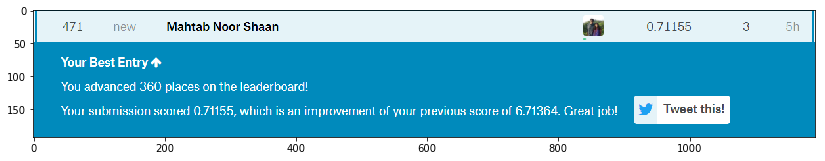

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mpl_toolkits.axes_grid1
plt.figure(figsize=(14,10))
img=mpimg.imread('Capture.png')
imgplot = plt.imshow(img)
plt.show()

## Logistic Regression:

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
NUM_CLASSES = 120

In [3]:
import numpy as np
train_x_bf = np.load(open('train_x_bf_full.npy', 'rb'))
valid_x_bf = np.load(open('valid_x_bf_full.npy', 'rb'))

In [6]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
logreg.fit(train_x_bf, (train_targets * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(valid_targets, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((valid_targets * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.8036561805043504
Validation Xception Accuracy 0.7883035282745288


## Discussion: 
We achieved a classification validation accuracy of almost 80% using bottleneck features from Xception model as input to a 2 layer neural network model. We also tried using bottleneck features from other models such as vgg16, vgg19, Resnet50. But these models had very low validation accuracy(10-15%). 

We could have performed even better if we could implement training deeper layers too and trained for more epochs; which was not possible due to less processing power.

Also, simple machine learning algorithms like logistic regression provided better results too(Validation accuracy of 78.9%).